<p style="font-size:30px"><b>Analyzing Recipe User Ratings via Recipe Complexity</b><p>
<br><br>
<p style="font-size:24px"><b>Contents</b><p>
<p style="text-indent: 40px">1. Introduction<br><p>
<p style="text-indent: 40px">2. Datasets and Methodology<br><p>
<p style="text-indent: 40px">3. Naive Complexity Measures<br><p>
<p style="text-indent: 40px">4. Technique Inclusion<br><p>
<p style="text-indent: 40px">5. Summary of Results<br><p>

<h3> 1. Introduction </h3>
<p>
The goal of this analysis is to study the following question:
    
    Does complexity of recipes affect user ratings positively or negatively?
    
This question seems natural because cooking is a both a practical skill and an art form, and users may be alternatively frustrated or inspired by attempting to implement a recipe which requires a more involved process, a longer duration, or a more difficult cooking technique.
    
 Of course "complexity" of a recipe is subjective, so to be more concrete, my purpose here is to study complexity in two forms: (1) "naive" complexity measures, namely duration of cook time, number of steps, and number of ingredients.  These measures are easy to quantify and compute correlations, but realistically may not be good indicators of a recipe's complexity.  And (2) technique inclusion: we may regard a recipe as being more complex or difficult if it requires a special technique like barbecue, emulsification, or poaching.  This notion of complexity better reflects my personal experience, having ruined a non-negligible number of eggs myself in the pursuit of a new skill.  Does a recipe's inclusion of a more sophisticated cooking technique translate to receiving a disproportionate number of 1 ratings or 5 ratings?

<h3> 2. Datasets and Methodology </h3>
<p>
We use datasets containing over 180K recipes from Food.com, together with over 700K user ratings, obtained from <a href="https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions">Kaggle.com</a>.  The datasets were scraped from Food.com by the hosts of the preceding Kaggle link, and they have provided both their raw datasets and some datasets that they cleaned for a machine learning project.  For this report, I found it advantageous to work with the raw datasets instead of the cleaned ones.
    
The raw datasets were too large to upload directly, so they were broken up into smaller csv files using a short simple Python script.  The scripts directly below reassemble them before working with them.
    
In order to study user ratings of recipes, we examine several kinds of outcomes: (1) mean rating, (2) one ratio, and (3) overall distribution of ratings.  The "one ratio" is defined to be the proportion of one ratings relative to all ratings received, i.e. (one rate) = (total number of one ratings) / (total number of ratings).  The reason I chose to include one ratio as a metric, in addition to mean rating, is that in this dataset one ratings are quite rare (approximately 1% of all ratings) and may be an indicator of a user's extreme displeasure with a particular recipe.
    
In Section 3 we analyze relationships between simple complexity measures (recipe cook time, number of steps, number of ingredients) and user rating outcomes (mean rating and one ratio) using Kendall's tau-b correlation.  We favor Kendall's tau over Pearson correlation here because we want to determine if there is a monotonic relationship between recipe complexity and rating outcomes, but we are not really concerned with the degree of linearity of the relationship.
    
In Section 4 we study technique inclusion, using a manually compiled list of 42 techniques (a subset of techniques from <a href="https://en.wikipedia.org/wiki/List_of_cooking_techniques">Wikipedia's list of cooking techniques</a>).  We use some tools from the Natural Language Processing Toolkit (NLTK) to extract techniques from each recipe's written description, and for each technique, we separate recipes which feature the technique and recipes which don't.  Since we are now switching to a binary classification of data, we apply one-sided Mann-Whitney U-tests to search for a statistically significant gap in mean ratings between the two groups, and similarly we search for a one ratio.  Here the null hypothesis, for each individual technique t, is
    
    H0: The probability that a random recipe which includes t has a lower (mean rating/one ratio) than a random recipe without t is equal to the probability that it has a higher (mean rating/one ratio).
    
The alternative hypothesis is
    
    H1: The probability that a random recipe which includes t has a lower (mean rating/one ratio) than a random recipe without t is greater than the probability that it has a higher (mean rating/one ratio).
    
Lastly, for each technique, we aggregate all ratings across the two groups and compare overall distributions via the one-sided Mann-Whitney U-test.  The hypotheses being tested are
    
    H0: The probability that a random user rating given to a recipe which includes t is lower than a random user rating given to a recipe without t is equal to the probability that it is higher.
    
    H1: The probability that a random user rating given to a recipe which includes t is lower than a random user rating given to a recipe without t is greater than the probability that it is higher.
    
For each of these tests, we provide estimates of the probabilities in question.
    
Below, we call up our datasets of interest and summarize some aspects of their macroscopic structure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from scipy.stats import kendalltau
from scipy.stats import mannwhitneyu
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('datasets-raw/RAW_recipes1.csv')
for i in [2,3,4,5]:
    dfappend = pd.read_csv('datasets-raw/RAW_recipes'+str(i)+'.csv')
    df = pd.concat([df,dfappend],ignore_index=True)
df.set_index('Unnamed: 0')

df.head(5)

,Unnamed: 0,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [3]:
interactions = pd.read_csv('datasets-raw/RAW_interactions1.csv')
for i in [2,3,4,5]:
    inappend = pd.read_csv('datasets-raw/RAW_interactions'+str(i)+'.csv')
    interactions = pd.concat([interactions,inappend],ignore_index=True)
    
interactions.head(5)

,Unnamed: 0,user_id,recipe_id,date,rating,review
0,0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


The total number of 5 ratings is 816364. (76.18747200238913% of all ratings)
The total number of 4 ratings is 187360. (17.48544124234732% of all ratings)
The total number of 3 ratings is 40855. (3.812807973719576% of all ratings)
The total number of 2 ratings is 14123. (1.31803419441541% of all ratings)
The total number of 1 ratings is 12818. (1.196244587128565% of all ratings)
The overall mean rating of recipes is 4.66149861878453.


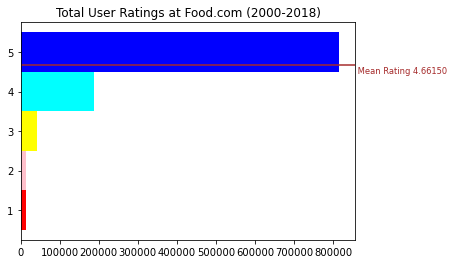

In [4]:
t5 = len(interactions[interactions['rating'] == 5])
t4 = len(interactions[interactions['rating'] == 4])
t3 = len(interactions[interactions['rating'] == 3])
t2 = len(interactions[interactions['rating'] == 2])
t1 = len(interactions[interactions['rating'] == 1])
s = t1+t2+t3+t4+t5
mean = (5*t5+4*t4+3*t3+2*t2+t1)/s

print('The total number of 5 ratings is ' + str(t5) +'. (' + str(100*t5/s) + '% of all ratings)')
print('The total number of 4 ratings is ' + str(t4) +'. (' + str(100*t4/s) + '% of all ratings)')
print('The total number of 3 ratings is ' + str(t3) +'. (' + str(100*t3/s) + '% of all ratings)')
print('The total number of 2 ratings is ' + str(t2) +'. (' + str(100*t2/s) + '% of all ratings)')
print('The total number of 1 ratings is ' + str(t1) +'. (' + str(100*t1/s) + '% of all ratings)')
print('The overall mean rating of recipes is ' + str(mean) + '.')

plt.figure()
length = [t1,t2,t3,t4,t5]
bars = ('1', '2', '3', '4', '5')
y_pos = np.arange(len(bars))
plt.barh(y_pos, length, height=1, color=['red','pink','yellow','cyan','blue'])
plt.yticks(y_pos, bars)
plt.title('Total User Ratings at Food.com (2000-2018)')
plt.axhline(y=mean-1,color='brown')
plt.text(x=plt.gca().get_xlim()[1], y=mean-1.2, horizontalalignment='left',
             s=' Mean Rating '+"{:.5f}".format(mean)+'  ', size='smaller', color='brown')
plt.show()

<h3> Naive Complexity Measures </h3>
<p>
In this section we compare three recipe complexity measures (cook time, number of steps, number of ingredients) with user rating outcomes (mean rating and one ratio) via Kendall's tau correlation.
    
First we extract and compile relevant data.  We drop all recipes which do not have any user ratings, and all recipes for which complexity data is missing.

In [5]:
df_compmeas = df[['name','minutes','n_steps','n_ingredients']]

interactions1 = interactions[['recipe_id','rating']].set_index('recipe_id').sort_index()
interactions1['rating2'] = interactions1['rating']
interactions1['is_five'] = (interactions1['rating'] == 5).astype(int)
interactions1['is_four'] = (interactions1['rating'] == 4).astype(int)
interactions1['is_three'] = (interactions1['rating'] == 3).astype(int)
interactions1['is_two'] = (interactions1['rating'] == 2).astype(int)
interactions1['is_one'] = (interactions1['rating'] == 1).astype(int)

recipe_ratings_info = (interactions1.groupby('recipe_id').agg({'rating':'mean','rating2':'count',
                                                               'is_five':'sum','is_four':'sum',
                                                               'is_three':'sum','is_two':'sum','is_one':'sum'}))
recipe_ratings_info.rename(columns={'rating':'mean_rating','rating2':'total_ratings',
                                    'is_five':'total_fives','is_four':'total_fours',
                                    'is_three':'total_threes','is_two':'total_twos',
                                    'is_one':'total_ones'},inplace=True)
recipe_ratings_info['one_ratio'] = recipe_ratings_info['total_ones'] / recipe_ratings_info['total_ratings']

df_compmeas = pd.merge(df_compmeas, recipe_ratings_info, how='inner', left_index=True, right_index=True)

df_compmeas

,name,minutes,n_steps,n_ingredients,mean_rating,total_ratings,total_fives,total_fours,total_threes,total_twos,total_ones,one_ratio
38,i can t believe it s spinach,30,5,8,4.250000,4,1,3,0,0,0,0.000000
39,i don t feel like cooking tonight casserole,45,6,8,3.000000,1,0,0,1,0,0,0.000000
40,i stole the idea from mirj sesame noodles,18,8,8,4.333333,9,6,2,0,0,1,0.111111
41,i yam what i yam two muffins,35,10,21,4.500000,2,1,1,0,0,0,0.000000
43,immoral sandwich filling loose meat,35,6,8,1.000000,1,0,0,0,0,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
231627,zwiebelwhe swiss onion tart,165,38,13,3.500000,2,0,1,1,0,0,0.000000
231629,zydeco salad,5,4,4,5.000000,1,1,0,0,0,0,0.000000
231631,zydeco shrimp wrap,57,14,11,5.000000,1,1,0,0,0,0,0.000000
231632,zydeco soup,60,7,22,4.600000,20,17,1,1,0,0,0.000000


In [6]:
df_compmeas[['minutes','n_steps','n_ingredients','total_ratings','mean_rating','one_ratio']].describe()

,minutes,n_steps,n_ingredients,total_ratings,mean_rating,one_ratio
count,1.281010e+05,128101.000000,128101.000000,128101.000000,128101.000000,128101.000000
mean,1.689290e+04,9.766083,9.047494,6.476577,4.340559,0.012863
std,6.000033e+06,5.973590,3.736184,22.995364,0.919952,0.084490
min,0.000000e+00,0.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000e+01,6.000000,6.000000,1.000000,4.000000,0.000000
50%,4.000000e+01,9.000000,9.000000,2.000000,4.636364,0.000000
75%,6.500000e+01,12.000000,11.000000,5.000000,5.000000,0.000000
max,2.147484e+09,113.000000,36.000000,1613.000000,5.000000,1.000000


Next, for each complexity measure, we aggregate mean rating and one ratio across all recipes and plot the data.

In [7]:
steps_v_ratings = (df_compmeas[['n_steps','total_ratings','total_fives','total_fours','total_threes','total_twos','total_ones']]
                   .groupby('n_steps').sum())
steps_v_ratings['mean_rating'] = (5*steps_v_ratings['total_fives'] + 4*steps_v_ratings['total_fours']
                                 + 3*steps_v_ratings['total_threes'] + 2*steps_v_ratings['total_twos']
                                 + 1*steps_v_ratings['total_ones']) / steps_v_ratings['total_ratings']
steps_v_ratings['one_ratio'] = steps_v_ratings['total_ones'] / steps_v_ratings['total_ratings']

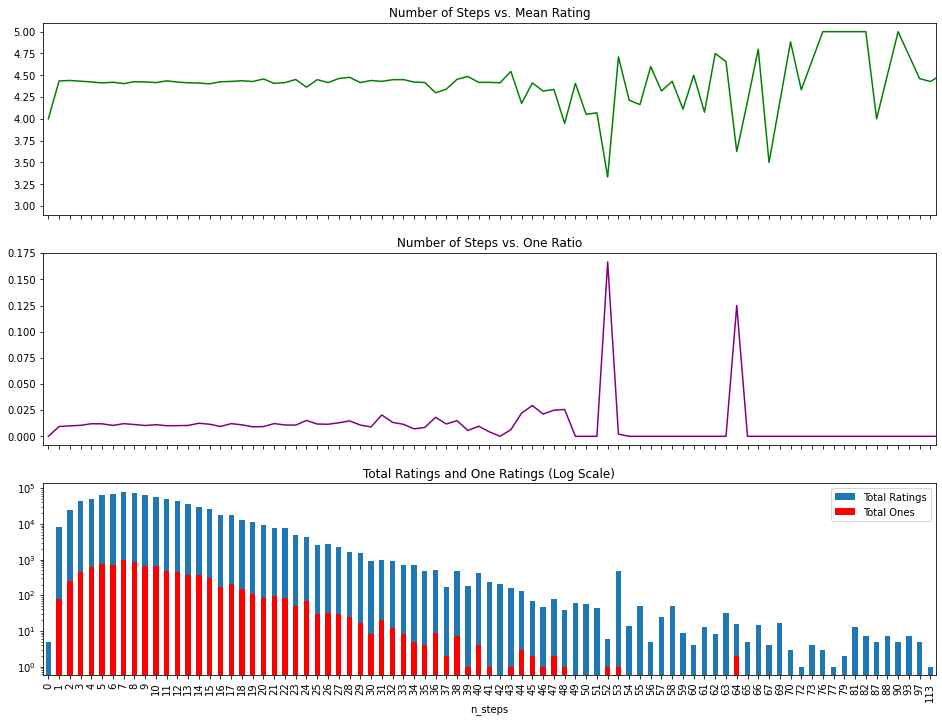

In [8]:
fig, ax = plt.subplots(3,1, figsize=(16,12), sharex=True)
steps_v_ratings['mean_rating'].plot(kind='line', color='green', label='Mean Rating', title='Number of Steps vs. Mean Rating', ax=ax[0])
steps_v_ratings['total_ratings'].plot(kind='bar', label='Total Ratings', title='Total Ratings and One Ratings (Log Scale)', logy=True, legend=True, ax=ax[2])
steps_v_ratings['total_ones'].plot(kind='bar', color='red', label='Total Ones', legend=True, ax=ax[2])
steps_v_ratings['one_ratio'].plot(kind='line', color='purple', label='One Ratio', title='Number of Steps vs. One Ratio', ax=ax[1])
fig.show()

In [9]:
ingredients_v_ratings = (df_compmeas[['n_ingredients','total_ratings','total_fives','total_fours','total_threes','total_twos','total_ones']]
                   .groupby('n_ingredients').sum())
ingredients_v_ratings['mean_rating'] = (5*ingredients_v_ratings['total_fives'] + 4*ingredients_v_ratings['total_fours']
                                 + 3*ingredients_v_ratings['total_threes'] + 2*ingredients_v_ratings['total_twos']
                                 + 1*ingredients_v_ratings['total_ones']) / ingredients_v_ratings['total_ratings']
ingredients_v_ratings['one_ratio'] = ingredients_v_ratings['total_ones'] / ingredients_v_ratings['total_ratings']

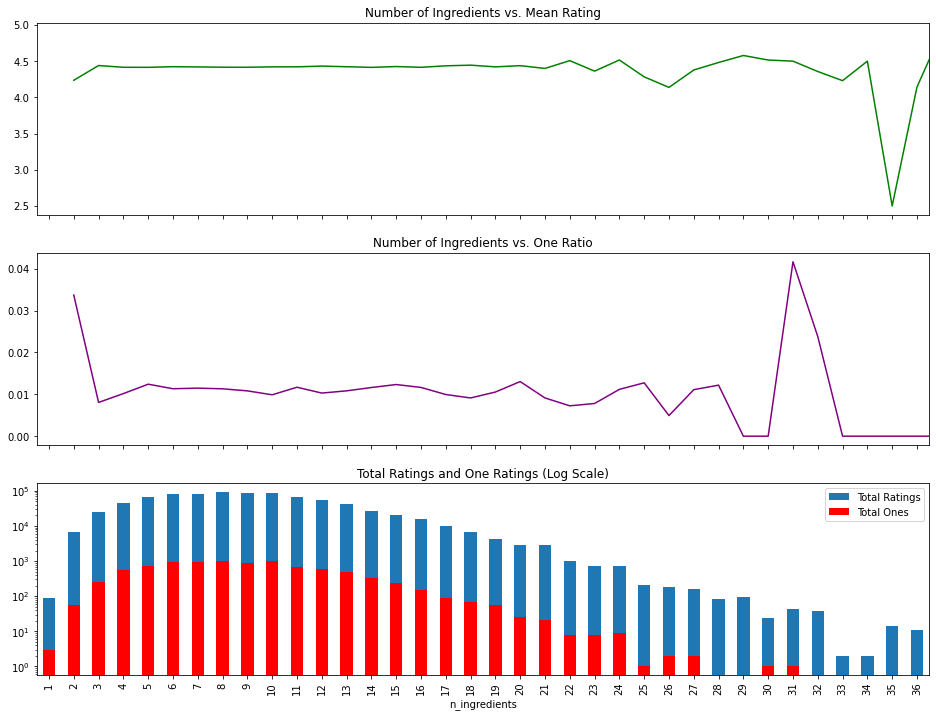

In [10]:
fig, ax = plt.subplots(3,1, figsize=(16,12), sharex=True)
ingredients_v_ratings['mean_rating'].plot(kind='line', color='green', label='Mean Rating', title='Number of Ingredients vs. Mean Rating', ax=ax[0])
ingredients_v_ratings['total_ratings'].plot(kind='bar', label='Total Ratings', title='Total Ratings and One Ratings (Log Scale)', logy=True, legend=True, ax=ax[2])
ingredients_v_ratings['total_ones'].plot(kind='bar', color='red', label='Total Ones', legend=True, ax=ax[2])
ingredients_v_ratings['one_ratio'].plot(kind='line', color='purple', label='One Ratio', title='Number of Ingredients vs. One Ratio', ax=ax[1])
fig.show()

In [11]:
mins_v_ratings = (df_compmeas[['minutes','total_ratings','total_fives','total_fours','total_threes','total_twos','total_ones']]
                   .groupby('minutes').sum())
mins_v_ratings['mean_rating'] = (5*mins_v_ratings['total_fives'] + 4*mins_v_ratings['total_fours']
                                 + 3*mins_v_ratings['total_threes'] + 2*mins_v_ratings['total_twos']
                                 + 1*mins_v_ratings['total_ones']) / mins_v_ratings['total_ratings']
mins_v_ratings['one_ratio'] = mins_v_ratings['total_ones'] / mins_v_ratings['total_ratings']

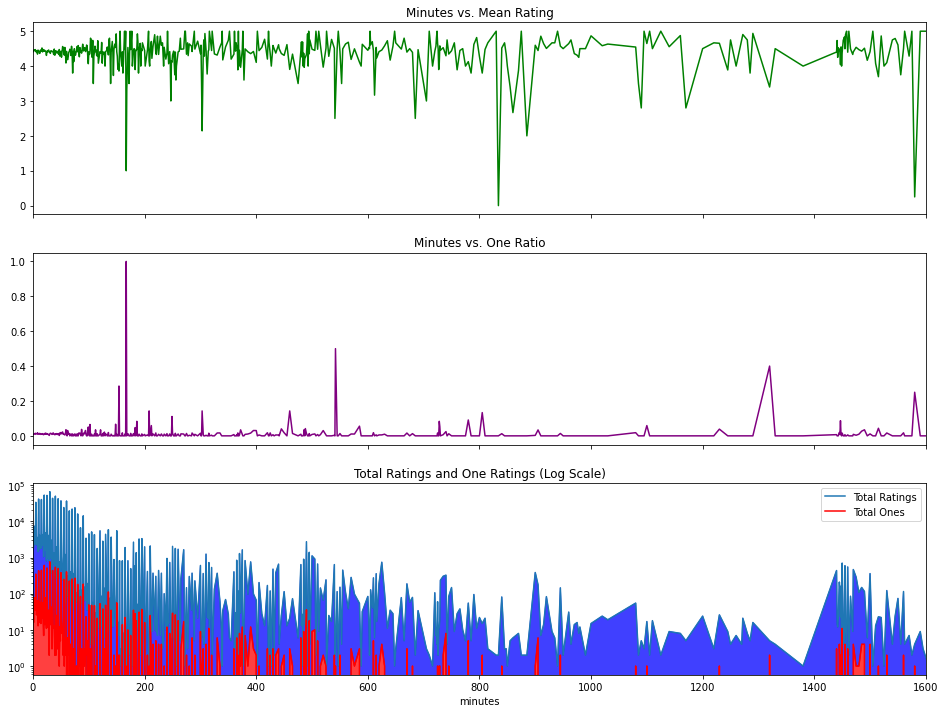

In [12]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(16,12))
mins_v_ratings['mean_rating'].plot(kind='line', color='green', label='Mean Rating', title='Minutes vs. Mean Rating', ax=ax[0])
mins_v_ratings['total_ratings'].plot(kind='line', label='Total Ratings', title='Total Ratings and One Ratings (Log Scale)', xlim=(0,1600), logy=True, legend=True, ax=ax[2])
mins_v_ratings['total_ones'].plot(kind='line', color='red', label='Total Ones', legend=True, ax=ax[2])
mins_v_ratings['one_ratio'].plot(kind='line', color='purple', label='One Rate', title='Minutes vs. One Ratio', ax=ax[1])

x = mins_v_ratings.index
y1 = mins_v_ratings['total_ones']
y2 = mins_v_ratings['total_ratings']
ax[2].fill_between(x,y1,y2,color='blue', alpha=0.75)
ax[2].fill_between(x,0,y1,color='red', alpha=0.75)

fig.show()

From the plots, it looks difficult to discern any monotonic relationship between a complexity measure and a rating outcome.  Next we compute Kendall's tau correlations, which confirm this intuition.

In [13]:
corr1 = df_compmeas[['minutes','n_steps','n_ingredients','mean_rating','one_ratio']].corr(method='kendall')

corr1

,minutes,n_steps,n_ingredients,mean_rating,one_ratio
minutes,1.000000,0.295679,0.261114,-0.000970,0.000462
n_steps,0.295679,1.000000,0.326945,-0.000463,0.000032
n_ingredients,0.261114,0.326945,1.000000,-0.001163,-0.001796
mean_rating,-0.000970,-0.000463,-0.001163,1.000000,-0.212371
one_ratio,0.000462,0.000032,-0.001796,-0.212371,1.000000


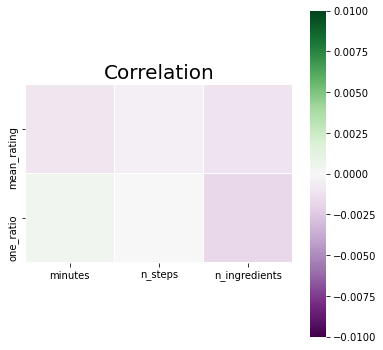

In [14]:
colormap = plt.cm.PRGn

plt.figure(figsize=(6,6))
plt.title('Correlation',size='20')
sns.heatmap(corr1.iloc[3:5,0:3],vmin=-0.01,vmax=0.01,cmap = colormap, center=0,linewidths=0.2,linecolor='white',square=True,annot=False)
plt.show()

The correlations above are effectively zero.  We conclude that this analysis provides no evidence of a monotonic relationship between any of the naive complexity measures (cook time, number of steps, number of ingredients) and the observed outcomes (mean rating and one ratio).

<h3> Technique Inclusion </h3>
<p>
In this section we use the Natural Language Toolkit (NLTK) to extract cooking techniques from recipe instructions, and we compare user rating outcomes (mean ratings and one ratios) for recipes which feature each technique vs. recipes which do not.  We apply one-sided Mann-Whitney tests to search for a statistically significant difference in outcomes across the two groups.  
    
The list of techniques we use is a manually collected subset of 42 techniques from <a href="https://en.wikipedia.org/wiki/List_of_cooking_techniques">Wikipedia's list of cooking techniques</a>, presented in the cell below.  A user could manully add a technique to the text file techniques.txt, and the remaining scripts will work with the new technique included.

In [15]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

In [16]:
df2 = pd.merge(df_compmeas.drop(columns=['minutes','n_steps','n_ingredients']),df['steps'].to_frame(),how='left',left_index=True,right_index=True)

df2

,name,mean_rating,total_ratings,total_fives,total_fours,total_threes,total_twos,total_ones,one_ratio,steps
38,i can t believe it s spinach,4.250000,4,1,3,0,0,0,0.000000,['combine all ingredients in a large bowl and ...
39,i don t feel like cooking tonight casserole,3.000000,1,0,0,1,0,0,0.000000,"['brown onion and meat in the oil , drain any ..."
40,i stole the idea from mirj sesame noodles,4.333333,9,6,2,0,0,1,0.111111,"['in a large pot , cook your angel hair pasta ..."
41,i yam what i yam two muffins,4.500000,2,1,1,0,0,0,0.000000,"['preheat oven to 375 degrees', 'add the brown..."
43,immoral sandwich filling loose meat,1.000000,1,0,0,0,0,1,1.000000,"['brown the meat & drain fat', 'stir in sugar ..."
...,...,...,...,...,...,...,...,...,...,...
231627,zwiebelwhe swiss onion tart,3.500000,2,0,1,1,0,0,0.000000,"['crust:', 'pulse flour , baking powder , and ..."
231629,zydeco salad,5.000000,1,1,0,0,0,0,0.000000,['place the lettuce on a platter or serving di...
231631,zydeco shrimp wrap,5.000000,1,1,0,0,0,0,0.000000,"['bring 3 quarts salted to water to a boil', '..."
231632,zydeco soup,4.600000,20,17,1,1,0,0,0.000000,"['heat oil in a 4-quart dutch oven', 'add cele..."


In [17]:
infile = open('datasets-raw/techniques.txt','r')
techniques = tokenizer.tokenize(infile.read())
techniques = [lemmatizer.lemmatize(w) for w in techniques]
infile.close()

techniques

['acidulate',
 'barbecue',
 'baste',
 'blanche',
 'boil',
 'braise',
 'brine',
 'broast',
 'caramelize',
 'casserole',
 'charbroil',
 'curdle',
 'cure',
 'deglaze',
 'degrease',
 'dredge',
 'emulsify',
 'ferment',
 'fillet',
 'flambe',
 'fry',
 'glaze',
 'grill',
 'macerate',
 'marinate',
 'microwave',
 'parbake',
 'parboil',
 'poach',
 'pressure',
 'puree',
 'roast',
 'saute',
 'sear',
 'shuck',
 'simmer',
 'smoke',
 'steam',
 'stew',
 'sweat',
 'tenderize',
 'zest']

Next we extract word tokens from each recipe's instructions, and lemmatize them.  The lemmatization process transforms words like "caramelization" to "caramelize" and "tenderizing" to "tenderize", etc., which helps ensure that we can locate our techniques in each recipe no matter how the words are chosen.  After lemmatizing, we reassemble the lemmatized sentences without punctuation so that we can easily extract techniques.

The script below may take a few minutes to run, and so I've commented it out.  The result has already been exported to 'datasets-cleaned/recipes_lemmatized.csv' and so we'll just retrieve it from the directory in this Notebook.

In [18]:
#df2['steps'] = (df2['steps'].apply(tokenizer.tokenize)
#                .apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
#                .apply(lambda x: ' '.join(x)))

#df2

In [19]:
#df2.to_csv('datasets-cleaned/recipes_lemmatized.csv')

In [20]:
df2 = pd.read_csv('datasets-cleaned/recipes_lemmatized.csv', index_col=0)

df2

,name,mean_rating,total_ratings,total_fives,total_fours,total_threes,total_twos,total_ones,one_ratio,steps
38,i can t believe it s spinach,4.250000,4,1,3,0,0,0,0.000000,combine all ingredient in a large bowl and mix...
39,i don t feel like cooking tonight casserole,3.000000,1,0,0,1,0,0,0.000000,brown onion and meat in the oil drain any exce...
40,i stole the idea from mirj sesame noodles,4.333333,9,6,2,0,0,1,0.111111,in a large pot cook your angel hair pasta unti...
41,i yam what i yam two muffins,4.500000,2,1,1,0,0,0,0.000000,preheat oven to 375 degree add the brown sugar...
43,immoral sandwich filling loose meat,1.000000,1,0,0,0,0,1,1.000000,brown the meat drain fat stir in sugar mustard...
...,...,...,...,...,...,...,...,...,...,...
231627,zwiebelwhe swiss onion tart,3.500000,2,0,1,1,0,0,0.000000,crust pulse flour baking powder and salt in a ...
231629,zydeco salad,5.000000,1,1,0,0,0,0,0.000000,place the lettuce on a platter or serving dish...
231631,zydeco shrimp wrap,5.000000,1,1,0,0,0,0,0.000000,bring 3 quart salted to water to a boil add in...
231632,zydeco soup,4.600000,20,17,1,1,0,0,0.000000,heat oil in a 4 quart dutch oven add celery on...


In [21]:
df3 = df2.dropna()

techniques_re = '('+'|'.join(techniques)+')'

df3['techniques'] = df3['steps'].str.findall(techniques_re)

df3

,name,mean_rating,total_ratings,total_fives,total_fours,total_threes,total_twos,total_ones,one_ratio,steps,techniques
38,i can t believe it s spinach,4.250000,4,1,3,0,0,0,0.000000,combine all ingredient in a large bowl and mix...,[]
39,i don t feel like cooking tonight casserole,3.000000,1,0,0,1,0,0,0.000000,brown onion and meat in the oil drain any exce...,[]
40,i stole the idea from mirj sesame noodles,4.333333,9,6,2,0,0,1,0.111111,in a large pot cook your angel hair pasta unti...,[fry]
41,i yam what i yam two muffins,4.500000,2,1,1,0,0,0,0.000000,preheat oven to 375 degree add the brown sugar...,[]
43,immoral sandwich filling loose meat,1.000000,1,0,0,0,0,1,1.000000,brown the meat drain fat stir in sugar mustard...,[simmer]
...,...,...,...,...,...,...,...,...,...,...,...
231627,zwiebelwhe swiss onion tart,3.500000,2,0,1,1,0,0,0.000000,crust pulse flour baking powder and salt in a ...,[]
231629,zydeco salad,5.000000,1,1,0,0,0,0,0.000000,place the lettuce on a platter or serving dish...,[]
231631,zydeco shrimp wrap,5.000000,1,1,0,0,0,0,0.000000,bring 3 quart salted to water to a boil add in...,"[boil, boil, saute]"
231632,zydeco soup,4.600000,20,17,1,1,0,0,0.000000,heat oil in a 4 quart dutch oven add celery on...,"[boil, simmer]"


In [22]:
for t in techniques:
    df3[t] = df3['techniques'].apply(lambda x: t in x).astype(int)
df3.drop(columns=['steps','techniques'], inplace=True)
    
df3

,name,mean_rating,total_ratings,total_fives,total_fours,total_threes,total_twos,total_ones,one_ratio,acidulate,...,saute,sear,shuck,simmer,smoke,steam,stew,sweat,tenderize,zest
38,i can t believe it s spinach,4.250000,4,1,3,0,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
39,i don t feel like cooking tonight casserole,3.000000,1,0,0,1,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
40,i stole the idea from mirj sesame noodles,4.333333,9,6,2,0,0,1,0.111111,0,...,0,0,0,0,0,0,0,0,0,0
41,i yam what i yam two muffins,4.500000,2,1,1,0,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
43,immoral sandwich filling loose meat,1.000000,1,0,0,0,0,1,1.000000,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231627,zwiebelwhe swiss onion tart,3.500000,2,0,1,1,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
231629,zydeco salad,5.000000,1,1,0,0,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
231631,zydeco shrimp wrap,5.000000,1,1,0,0,0,0,0.000000,0,...,1,0,0,0,0,0,0,0,0,0
231632,zydeco soup,4.600000,20,17,1,1,0,0,0.000000,0,...,0,0,0,1,0,0,0,0,0,0


Next, for each technique featured in at least 20 recipes, we conduct a Mann-Whitney U-test to compare mean rating outcomes for recipes with and without the technique.  For these tests, each recipe counts as a single data point.  The null hypothesis for these tests takes the form
    
    H0: The probability that a random recipe which includes t has a lower mean rating than a random recipe without t is equal to the probability that it has a higher mean rating.
    
The alternative hypothesis is
    
    H1: The probability that a random recipe which includes t has a lower mean rating than a random recipe without t is greater than the probability that it has a higher mean rating.
    
We report the p-value for each test and if $p < 0.05$, we reject the null hypothesis with confidence $1 - p$.  We also report an estimate (the rho statistic) for the probability stated in the null hypothesis.

If a technique does not appear in at least 20 recipes, we drop it from the calculation.

The report is organized in order of p-value, from rating-damaging techniques --> rating-improving techniques.

In [23]:
recipes_with_counts = []

for t in techniques:
    dft1 = df3[df3[t] == 1]
    n = len(dft1.index)
    if n >= 20:
        recipes_with_counts += [(t,n)]

techs_MW_report1 = pd.Series(list(zip(*recipes_with_counts))[1],index=list(zip(*recipes_with_counts))[0]).to_frame('recipes_with')
techs_MW_report1.index.name = 'techniques'
num_recipes = len(df3.index)
techs_MW_report1['recipes_without'] = num_recipes - techs_MW_report1['recipes_with']

U_values1 = []
p_values1 = []
rho_values1 = []
summaries1 = []

for t in techs_MW_report1.index:
    dft1 = df3[df3[t] == 1]
    dft0 = df3[df3[t] == 0]
    U,p = mannwhitneyu(dft1['mean_rating'],dft0['mean_rating'],alternative='less')
    rho = U/(techs_MW_report1['recipes_with'].loc[t] * techs_MW_report1['recipes_without'].loc[t])
    U_values1 += [U]
    p_values1 += [p]
    rho_values1 += [rho]
    if p <= 0.01:
        summary = ('99% confidence rejection of null hypothesis.  We estimate a random recipe with "' + t + '" will receive '
        + 'a lower mean rating than a random recipe without "' + t + '" with probability ' + str(1 - rho) + '.')
    elif p <= 0.05:
        summary = ('95% confidence rejection of null hypothesis.  We estimate a random recipe with "' + t + '" will receive '
        + 'a lower mean rating than a random recipe without "' + t + '" with probability ' + str(1 - rho) + '.')
    elif p >= 0.95:
        summary = ('95% confidence rejection of null hypothesis.  We estimate a random recipe with "' + t + '" will receive '
        + 'a higher mean rating than a random recipe without "' + t + '" with probability ' + str(rho) + '.')
    elif p >= 0.99:
        summary = ('99% confidence rejection of null hypothesis.  We estimate a random recipe with "' + t + '" will receive '
        + 'a higher mean rating than a random recipe without "' + t + '" with probability ' + str(rho) + '.')
    else:
        summary = 'We cannot reject the null hypothesis.'
    summaries1 += [summary]
    
techs_MW_report1['U_statistic'] = U_values1
techs_MW_report1['p_value'] = p_values1
techs_MW_report1['rho_value'] = rho_values1
techs_MW_report1['summary'] = summaries1

techs_MW_report1.sort_values('p_value', inplace=True)
techs_MW_report1

techs_MW_report1

,recipes_with,recipes_without,U_statistic,p_value,rho_value,summary
techniques,,,,,,
blanche,109,127991,6.363020e+06,0.051324,0.456097,We cannot reject the null hypothesis.
poach,289,127811,1.780588e+07,0.138854,0.482056,We cannot reject the null hypothesis.
fillet,1273,126827,7.973552e+07,0.219055,0.493869,We cannot reject the null hypothesis.
tenderize,120,127980,7.418758e+06,0.254479,0.483068,We cannot reject the null hypothesis.
cure,981,127119,6.185767e+07,0.329795,0.496037,We cannot reject the null hypothesis.
puree,3662,124438,2.269165e+08,0.332365,0.497960,We cannot reject the null hypothesis.
caramelize,823,127277,5.205638e+07,0.378524,0.496963,We cannot reject the null hypothesis.
steam,3007,125093,1.878704e+08,0.457723,0.499450,We cannot reject the null hypothesis.
ferment,63,128037,4.003258e+06,0.458263,0.496292,We cannot reject the null hypothesis.


The report contains detailed summaries of the conclusions of each U-test in the last column.  See below for the more interesting examples.

In [24]:
techs_MW_report1['summary'].loc['boil']

'95% confidence rejection of null hypothesis.  We estimate a random recipe with "boil" will receive a higher mean rating than a random recipe without "boil" with probability 0.5032193719208004.'

In [25]:
techs_MW_report1['summary'].loc['roast']

'95% confidence rejection of null hypothesis.  We estimate a random recipe with "roast" will receive a higher mean rating than a random recipe without "roast" with probability 0.5075669601888548.'

In [26]:
techs_MW_report1['summary'].loc['microwave']

'95% confidence rejection of null hypothesis.  We estimate a random recipe with "microwave" will receive a higher mean rating than a random recipe without "microwave" with probability 0.5083750115487727.'

Now we repeat the U-tests as above, but we test one ratios instead of mean ratings.  The null hypothesis and alternative hypothesis are respectively
    
    H0: The probability that a random recipe which includes t has a lower one ratio than a random recipe without t is equal to the probability that it has a higher one ratio.
    
    H1: The probability that a random recipe which includes t has a lower one ratio than a random recipe without t is greater than the probability that it has a higher one ratio.
    
The report is organized in order of p-value, from rating-damaging techniques --> rating-improving techniques.

In [27]:
recipes_with_counts = []

for t in techniques:
    dft1 = df3[df3[t] == 1]
    n = len(dft1.index)
    if n >= 20:
        recipes_with_counts += [(t,n)]

techs_MW_report2 = pd.Series(list(zip(*recipes_with_counts))[1],index=list(zip(*recipes_with_counts))[0]).to_frame('recipes_with')
techs_MW_report2.index.name = 'techniques'
num_recipes = len(df3.index)
techs_MW_report2['recipes_without'] = num_recipes - techs_MW_report2['recipes_with']

U_values2 = []
p_values2 = []
rho_values2 = []
summaries2 = []

for t in techs_MW_report2.index:
    dft1 = df3[df3[t] == 1]
    dft0 = df3[df3[t] == 0]
    U,p = mannwhitneyu(dft1['one_ratio'],dft0['one_ratio'],alternative='less')
    rho = U/(techs_MW_report2['recipes_with'].loc[t] * techs_MW_report2['recipes_without'].loc[t])
    U_values2 += [U]
    p_values2 += [p]
    rho_values2 += [rho]
    if p <= 0.01:
        summary = ('99% confidence rejection of null hypothesis.  We estimate a random recipe with "' + t + '" will have '
        + 'a lower one ratio than a random recipe without "' + t + '" with probability ' + str(1 - rho) + '.')
    elif p <= 0.05:
        summary = ('95% confidence rejection of null hypothesis.  We estimate a random recipe with "' + t + '" will have '
        + 'a lower one ratio than a random recipe without "' + t + '" with probability ' + str(1 - rho) + '.')
    elif p >= 0.95:
        summary = ('95% confidence rejection of null hypothesis.  We estimate a random recipe with "' + t + '" will have '
        + 'a higher one ratio than a random recipe without "' + t + '" with probability ' + str(rho) + '.')
    elif p >= 0.99:
        summary = ('99% confidence rejection of null hypothesis.  We estimate a random recipe with "' + t + '" will have '
        + 'a higher one ratio than a random recipe without "' + t + '" with probability ' + str(rho) + '.')
    else:
        summary = 'We cannot reject the null hypothesis.'
    summaries2 += [summary]
    
techs_MW_report2['U_statistic'] = U_values2
techs_MW_report2['p_value'] = p_values2
techs_MW_report2['rho_value'] = rho_values2
techs_MW_report2['summary'] = summaries2

techs_MW_report2.sort_values('p_value', ascending = False, inplace=True)
techs_MW_report2

techs_MW_report2

,recipes_with,recipes_without,U_statistic,p_value,rho_value,summary
techniques,,,,,,
caramelize,823,127277,5.304799e+07,0.951751,0.506430,95% confidence rejection of null hypothesis. ...
tenderize,120,127980,7.931788e+06,0.948503,0.516473,We cannot reject the null hypothesis.
shuck,38,128062,2.569510e+06,0.940729,0.528015,We cannot reject the null hypothesis.
simmer,21531,106569,1.150152e+09,0.935811,0.501257,We cannot reject the null hypothesis.
cure,981,127119,6.299581e+07,0.927365,0.505164,We cannot reject the null hypothesis.
blanche,109,127991,7.185719e+06,0.922409,0.515068,We cannot reject the null hypothesis.
dredge,1215,126885,7.775649e+07,0.914772,0.504371,We cannot reject the null hypothesis.
fry,11396,116704,6.667818e+08,0.894036,0.501355,We cannot reject the null hypothesis.
sear,798,127302,5.122894e+07,0.862405,0.504286,We cannot reject the null hypothesis.


In [28]:
techs_MW_report2['summary'].loc['caramelize']

'95% confidence rejection of null hypothesis.  We estimate a random recipe with "caramelize" will have a higher one ratio than a random recipe without "caramelize" with probability 0.5064296956196352.'

In [29]:
techs_MW_report2['summary'].loc['puree']

'95% confidence rejection of null hypothesis.  We estimate a random recipe with "puree" will have a lower one ratio than a random recipe without "puree" with probability 0.5037703375654935.'

In [30]:
techs_MW_report2['summary'].loc['pressure']

'99% confidence rejection of null hypothesis.  We estimate a random recipe with "pressure" will have a lower one ratio than a random recipe without "pressure" with probability 0.5163132837579412.'

Below we display a heat map of our probability estimates of increased mean rating, and decreased one ratio.  The visual shorthand is:

-GREEN represents likelihood to improve the recipe rating, and

-PURPLE represents likelihood to damage the recipe rating.

The heat map does not take into account statistical significances of these estimates.

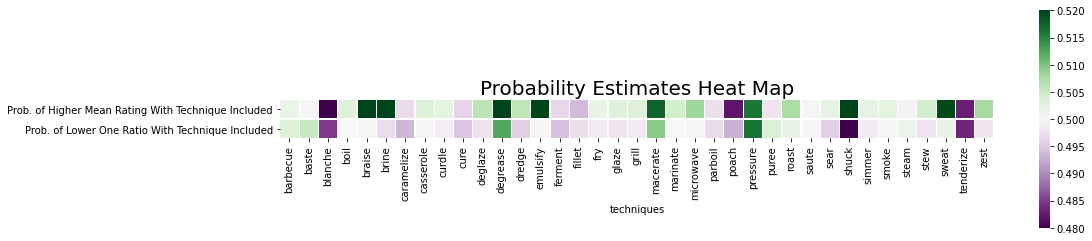

In [31]:
rho_values = pd.merge(techs_MW_report1['rho_value'].sort_index(),techs_MW_report2['rho_value'],how='left',left_index=True,right_index=True)
rho_values.rename(columns={'rho_value_x':'Prob. of Higher Mean Rating With Technique Included','rho_value_y':'Prob. of Lower One Ratio With Technique Included'}, inplace=True)
rho_values['Prob. of Lower One Ratio With Technique Included'] = 1 - rho_values['Prob. of Lower One Ratio With Technique Included']

plt.figure(figsize=(16,4))
plt.title('Probability Estimates Heat Map',size='20')
sns.heatmap(rho_values.transpose(),vmin=0.48,vmax=0.52,cmap=colormap,linewidths=0.2,linecolor='white',square=True,annot=False)
plt.show()

Next, for each technique, we aggregate all ratings across all recipes which feature that technique vs. those that don't.  Then we'll plot the new aggregate mean ratings and one ratios to get a sense of the overall impact of techniques on user ratings.

In [32]:
tech_nums = range(0,len(techniques))
tech_dict = dict(zip(tech_nums,techniques))

techs = pd.Series(tech_dict).to_frame()

total_ratings_with = []
total_ratings_without = []
total_fives_with = []
total_fives_without = []
total_fours_with = []
total_fours_without = []
total_threes_with = []
total_threes_without = []
total_twos_with = []
total_twos_without = []
total_ones_with = []
total_ones_without = []
for i in tech_dict.keys():
    tech_i = df3[[tech_dict[i],'total_ratings','total_fives','total_fours','total_threes','total_twos','total_ones']].groupby(tech_dict[i]).sum()
    total_ratings_without += [tech_i.iloc[0]['total_ratings']]
    total_fives_without += [tech_i.iloc[0]['total_fives']]
    total_fours_without += [tech_i.iloc[0]['total_fours']]
    total_threes_without += [tech_i.iloc[0]['total_threes']]
    total_twos_without += [tech_i.iloc[0]['total_twos']]
    total_ones_without += [tech_i.iloc[0]['total_ones']]
    if len(tech_i) == 2:
        ratings_with = tech_i.iloc[1]['total_ratings']
        fives_with = tech_i.iloc[1]['total_fives']
        fours_with = tech_i.iloc[1]['total_fours']
        threes_with = tech_i.iloc[1]['total_threes']
        twos_with = tech_i.iloc[1]['total_twos']
        ones_with = tech_i.iloc[1]['total_ones']
    else:
        ratings_with = 0
        fives_with = 0
        fours_with = 0
        threes_with = 0
        twos_with = 0
        ones_with = 0
    total_ratings_with += [ratings_with]
    total_fives_with += [fives_with]
    total_fours_with += [fours_with]
    total_threes_with += [threes_with]
    total_twos_with += [twos_with]
    total_ones_with += [ones_with]
techs['total_ratings_with'] = pd.Series(total_ratings_with)
techs['total_fives_with'] = pd.Series(total_fives_with)
techs['total_fours_with'] = pd.Series(total_fours_with)
techs['total_threes_with'] = pd.Series(total_threes_with)
techs['total_twos_with'] = pd.Series(total_twos_with)
techs['total_ones_with'] = pd.Series(total_ones_with)
techs['total_ratings_without'] = pd.Series(total_ratings_without)
techs['total_fives_without'] = pd.Series(total_fives_without)
techs['total_fours_without'] = pd.Series(total_fours_without)
techs['total_threes_without'] = pd.Series(total_threes_without)
techs['total_twos_without'] = pd.Series(total_twos_without)
techs['total_ones_without'] = pd.Series(total_ones_without)
techs['mean_rating_with'] = (5*techs['total_fives_with'] + 4*techs['total_fours_with'] + 3*techs['total_threes_with']
                             + 2*techs['total_twos_with'] + 1*techs['total_ones_with']) / techs['total_ratings_with']
techs['mean_rating_without'] = (5*techs['total_fives_without'] + 4*techs['total_fours_without'] + 3*techs['total_threes_without']
                             + 2*techs['total_twos_without'] + 1*techs['total_ones_without']) / techs['total_ratings_without']
techs['one_ratio_with'] = techs['total_ones_with'] / techs['total_ratings_with']
techs['one_ratio_without'] = techs['total_ones_without'] / techs['total_ratings_without']
techs.set_index(0, inplace=True)
techs.index.name= 'techniques'

techs

,total_ratings_with,total_fives_with,total_fours_with,total_threes_with,total_twos_with,total_ones_with,total_ratings_without,total_fives_without,total_fours_without,total_threes_without,total_twos_without,total_ones_without,mean_rating_with,mean_rating_without,one_ratio_with,one_ratio_without
techniques,,,,,,,,,,,,,,,,
acidulate,35,26,7,1,0,0,829616,598642,137510,31193,10973,9157,4.600000,4.421241,0.000000,0.011038
barbecue,5670,4031,1043,199,71,54,823981,594637,136474,30995,10902,9103,4.430335,4.421186,0.009524,0.011048
baste,4154,2954,734,167,65,41,825497,595714,136783,31027,10908,9116,4.424169,4.421234,0.009870,0.011043
blanche,1282,961,198,38,18,12,828369,597707,137319,31156,10955,9145,4.492200,4.421138,0.009360,0.011040
boil,201382,145123,33487,7520,2837,2339,628269,453545,104030,23674,8136,6818,4.420137,4.421604,0.011615,0.010852
braise,624,458,99,26,9,8,829027,598210,137418,31168,10964,9149,4.471154,4.421211,0.012821,0.011036
brine,1543,1075,302,53,26,17,828108,597593,137215,31141,10947,9140,4.414128,4.421261,0.011017,0.011037
broast,1,0,1,0,0,0,829650,598668,137516,31194,10973,9157,4.000000,4.421249,0.000000,0.011037
caramelize,5390,3733,914,205,84,148,824261,594935,136603,30989,10889,9009,4.313915,4.421950,0.027458,0.010930


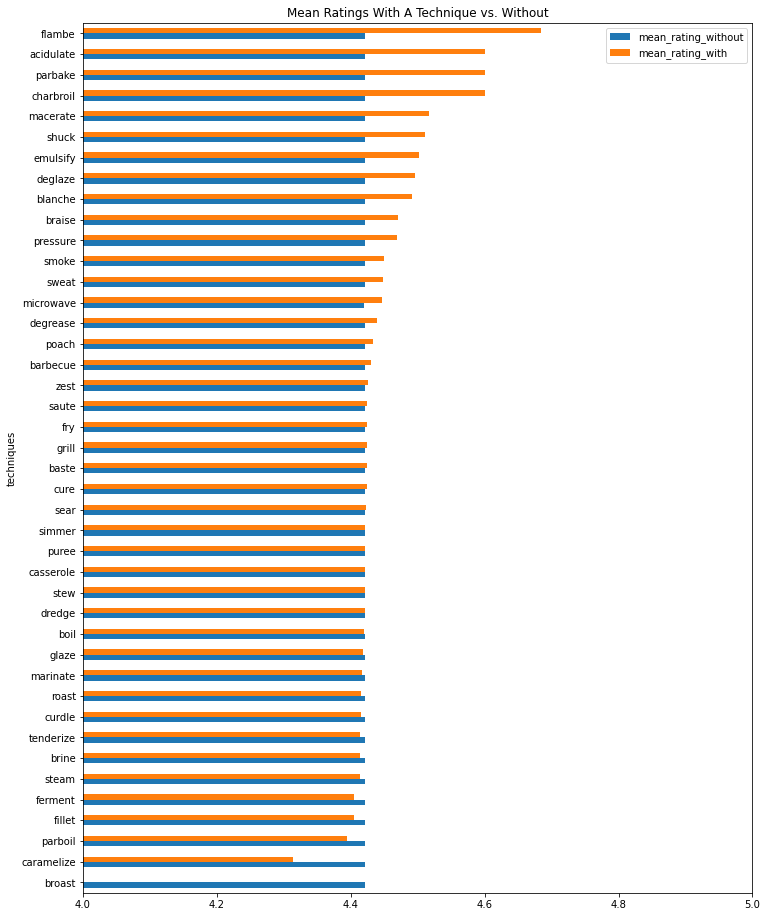

In [33]:
techs[['mean_rating_without','mean_rating_with']].sort_values('mean_rating_with').plot(kind='barh', figsize=(12,16), xlim=(4,5), legend=True, title='Mean Ratings With A Technique vs. Without')

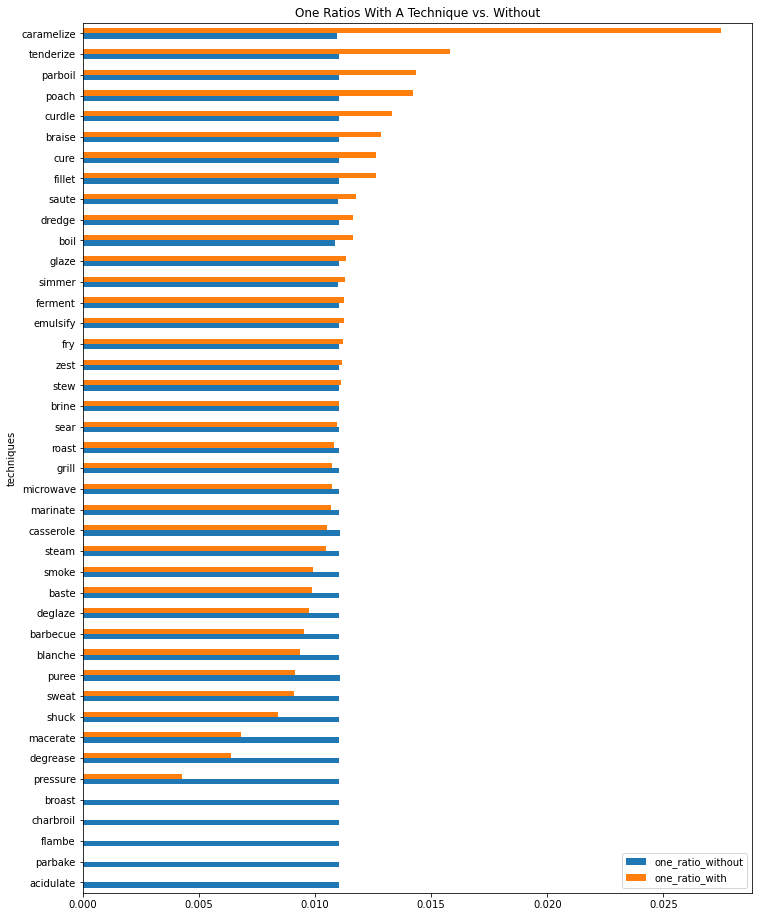

In [34]:
techs[['one_ratio_without','one_ratio_with']].sort_values('one_ratio_with').plot(kind='barh', figsize=(12,16), legend=True, title='One Ratios With A Technique vs. Without')

Next we want to compute statistical significance of the differences plotted above via Mann-Whitney U-test.

We test the entire distribution of ratings for recipes which include the technique vs. those which don't.  For these tests, each rating counts as a single data point.  The null hypothesis for these tests takes the form
    
    H0: The probability that a random rating of a recipe which includes t is lower than a random rating of a recipe without t is equal to the probability that it is higher.
    
The alternative hypothesis is
    
    H1: The probability that a random rating of a recipe which includes t is lower than a random rating of a recipe without t is greater than the probability that it is higher.
    
We report the p-value for each test and if $p < 0.05$, we reject the null hypothesis with confidence $1 - p$.  We also report an estimate (the rho statistic) for the probability stated in the null hypothesis.

If a technique does not have at least 20 ratings among all recipes, we drop it from the calculation.  The report is organized in order of p-value, from rating-damaging techniques --> rating-improving techniques.

In [35]:
techs_MW_report3 = techs[['total_ratings_with','total_ratings_without','mean_rating_with','mean_rating_without']]
techs_MW_report3 = techs_MW_report3.drop(techs_MW_report3[techs_MW_report3['total_ratings_with'] < 20].index)

U_values3 = []
p_values3 = []
rho_values3 = []
summaries3 = []

for t in techs_MW_report3.index:
    i1 = techs['total_fives_with'].loc[t]
    i2 = i1 + techs['total_fours_with'].loc[t]
    i3 = i2 + techs['total_threes_with'].loc[t]
    i4 = i3 + techs['total_twos_with'].loc[t]
    i5 = i4 + techs['total_ones_with'].loc[t]

    j1 = techs['total_fives_without'].loc[t]
    j2 = j1 + techs['total_fours_without'].loc[t]
    j3 = j2 + techs['total_threes_without'].loc[t]
    j4 = j3 + techs['total_twos_without'].loc[t]
    j5 = j4 + techs['total_ones_without'].loc[t]

    ratings_with = np.zeros((i5,1))
    ratings_with[:i1] = ratings_with[:i1] + 5
    ratings_with[i1:i2] = ratings_with[i1:i2] + 4
    ratings_with[i2:i3] = ratings_with[i2:i3] + 3
    ratings_with[i3:i4] = ratings_with[i3:i4] + 2
    ratings_with[i4:i5] = ratings_with[i4:i5] + 1

    ratings_without = np.zeros((j5,1))
    ratings_without[:j1,0] = ratings_without[:j1,0] + 5
    ratings_without[j1:j2,0] = ratings_without[j1:j2,0] + 4
    ratings_without[j2:j3,0] = ratings_without[j2:j3,0] + 3
    ratings_without[j3:j4,0] = ratings_without[j3:j4,0] + 2
    ratings_without[j4:j5,0] = ratings_without[j4:j5,0] + 1

    U,p = mannwhitneyu(ratings_with,ratings_without,alternative='less')
    rho = U/(i5*j5)
    U_values3 += [U]
    p_values3 += [p]
    rho_values3 += [rho]
    if p <= 0.01:
        summary = ('99% confidence rejection of null hypothesis.  We estimate a random rating of a recipe with "' + t + '" will '
        'be lower than a random rating of a recipe without "' + t + '" with probability ' + str(1 - rho) + '.')
    elif p <= 0.05:
        summary = ('95% confidence rejection of null hypothesis.  We estimate a random rating of a recipe with "' + t + '" will '
        'be lower than a random rating of a recipe without "' + t + '" with probability ' + str(1 - rho) + '.')
    elif p >= 0.95:
        summary = ('95% confidence rejection of null hypothesis.  We estimate a random rating of a recipe with "' + t + '" will '
        'be higher than a random rating of a recipe without "' + t + '" with probability ' + str(rho) + '.')
    elif p >= 0.99:
        summary = ('99% confidence rejection of null hypothesis.  We estimate a random rating of a recipe with "' + t + '" will '
        'be higher than a random rating of a recipe without "' + t + '" with probability ' + str(rho) + '.')
    else:
        summary = 'We cannot reject the null hypothesis.'
    summaries3 += [summary]
    
techs_MW_report3['U_statistic'] = U_values3
techs_MW_report3['p_value'] = p_values3
techs_MW_report3['rho_value'] = rho_values3
techs_MW_report3['summary'] = summaries3

techs_MW_report3.sort_values('p_value', inplace=True)
techs_MW_report3

,total_ratings_with,total_ratings_without,mean_rating_with,mean_rating_without,U_statistic,p_value,rho_value,summary
techniques,,,,,,,,
caramelize,5390,824261,4.313915,4.421950,1.928421e+09,2.512984e-07,0.484790,99% confidence rejection of null hypothesis. ...
steam,17983,811668,4.413224,4.421426,6.495151e+09,1.491107e-05,0.493056,99% confidence rejection of null hypothesis. ...
brine,1543,828108,4.414128,4.421261,5.623203e+08,5.311418e-03,0.485667,99% confidence rejection of null hypothesis. ...
boil,201382,628269,4.420137,4.421604,5.688855e+10,1.491161e-02,0.498772,95% confidence rejection of null hypothesis. ...
baste,4154,825497,4.424169,4.421234,1.529471e+09,1.781028e-02,0.492800,95% confidence rejection of null hypothesis. ...
barbecue,5670,823981,4.430335,4.421186,2.086907e+09,2.644574e-02,0.494313,95% confidence rejection of null hypothesis. ...
stew,5484,824167,4.421590,4.421246,2.023485e+09,5.542627e-02,0.495239,We cannot reject the null hypothesis.
tenderize,760,828891,4.414474,4.421254,2.793296e+08,7.214331e-02,0.488347,We cannot reject the null hypothesis.
saute,66278,763373,4.425134,4.420911,2.276951e+10,9.891235e-02,0.498849,We cannot reject the null hypothesis.


In [36]:
techs_MW_report3['summary'].loc['caramelize']

'99% confidence rejection of null hypothesis.  We estimate a random rating of a recipe with "caramelize" will be lower than a random rating of a recipe without "caramelize" with probability 0.5152101036422023.'

In [37]:
techs_MW_report3['summary'].loc['steam']

'99% confidence rejection of null hypothesis.  We estimate a random rating of a recipe with "steam" will be lower than a random rating of a recipe without "steam" with probability 0.5069435913566656.'

In [38]:
techs_MW_report3['summary'].loc['brine']

'99% confidence rejection of null hypothesis.  We estimate a random rating of a recipe with "brine" will be lower than a random rating of a recipe without "brine" with probability 0.5143330430768176.'

<h3> 5. Summary of Results </h3>
<p>
In this analysis we looked for correlations between recipe complexity and user rating outcomes.  We measured recipe complexity by "naive" measures (cook time, number of steps, and number of ingredients) and by technique inclusion for 42 manually selected techniques.  We measured rating outcomes by three different standards: mean rating of individual recipes, one ratio of individual recipes, and overall distribution of individual ratings.
    
We found no evidence of correlation between any of the naive measures (cook time, number of steps, number of ingredients) with the outcomes of mean rating or one ratio.
    
Regarding technique inclusion, this report finds strong evidence that inclusion of the technique 'caramelize' is damaging to user ratings of recipes.  A random recipe with 'caramelize' is likely to have a higher one ratio than a random recipe without (sample probability 50.64%; null hypothesis rejected with 95% confidence), and a random user rating of a recipe with 'caramelize' will be lower than than one without (sample probability 51.52%; null hypothesis rejected with 99% confidence).
    
We find evidence that inclusion of the technique 'roast' improves mean ratings (sample probability 50.76%, null hypothesis rejected with 95% confidence), as does the technique 'microwave' improves mean ratings (sample probability 50.84%, null hypothesis rejected with 95% confidence).  Moreover, 'roast' and 'microwave' both decrease the one ratio and increase the overall rating distribution in the analyzed sample.  But the latter two findings are not statistically significant, so more evidence is needed to assume that 'roast' improves user ratings.
    
We find with high confidence that 'steam', 'brine', 'boil', 'baste', and 'barbecue' damage rating distributions, but may actually lower one ratio or increase mean rating (in the case of 'boil', in a statistically significant way).  Conversely, we with high confidence that 'puree', and 'pressure' improve mean ratings or decrease one ratios, but they each appear to damage overall rating distributions in the analyzed sample.  So we regard these latter findings as inconclusive.

In [39]:
print(techs_MW_report2['summary'].loc['caramelize'])
print()
print(techs_MW_report3['summary'].loc['caramelize'])
print()
print(techs_MW_report1['summary'].loc['roast'])
print()
print(techs_MW_report1['summary'].loc['microwave'])

95% confidence rejection of null hypothesis.  We estimate a random recipe with "caramelize" will have a higher one ratio than a random recipe without "caramelize" with probability 0.5064296956196352.

99% confidence rejection of null hypothesis.  We estimate a random rating of a recipe with "caramelize" will be lower than a random rating of a recipe without "caramelize" with probability 0.5152101036422023.

95% confidence rejection of null hypothesis.  We estimate a random recipe with "roast" will receive a higher mean rating than a random recipe without "roast" with probability 0.5075669601888548.

95% confidence rejection of null hypothesis.  We estimate a random recipe with "microwave" will receive a higher mean rating than a random recipe without "microwave" with probability 0.5083750115487727.


If recipe authors or Food.com proprietors want recipes to receive higher ratings, this study finds strong evidence that it is risky to include caramelization, as recipes including caramelization have much higher one ratios and lower rating distributions.  On the other hand, roasting and microwaving are safe techniques with mostly positive impact on user ratings.

In [40]:
#df_compmeas.to_csv('datasets-cleaned/recipe_complexity_measures.csv')
#techs.to_csv('datasets-cleaned/technique_distributions.csv')
#techs_MW_report1.to_csv('reports/techs_MW_report1.csv')
#techs_MW_report2.to_csv('reports/techs_MW_report2.csv')
#techs_MW_report3.to_csv('reports/techs_MW_report3.csv')